# Sequence to Sequence Models for Timeseries Regression


In this notebook we are going to tackle a harder problem: 
- predicting the future on a timeseries
- using an LSTM
- with rough uncertainty (uncalibrated)
- outputing sequence of predictions

<img src="../reports/figures/Seq2Seq for regression.png" />




- [ ] TODO mike autocorrelation baseline
- [x] TODO mike acorn data
- [ ] TODO mike handle multiple houses. Multiindex

In [1]:
# OPTIONAL: Load the "autoreload" extension so that code can change. But blacklist large modules
%load_ext autoreload
%autoreload 2
%aimport -pandas
%aimport -torch
%aimport -numpy
%aimport -matplotlib
%aimport -dask
%aimport -tqdm
%matplotlib inline

In [51]:
# Imports
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
import torch
import torch.utils.data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12.0, 4.0)
plt.style.use('ggplot')

from pathlib import Path
from tqdm.auto import tqdm

import pytorch_lightning as pl

In [3]:
from seq2seq_time.data.dataset import Seq2SeqDataSet, Seq2SeqDataSets
from seq2seq_time.predict import predict

In [4]:
import logging, sys
# logging.basicConfig(stream=sys.stdout, level=logging.INFO)

## Parameters

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'using {device}')

columns_target=['energy(kWh/hh)']
window_past = 48*4
window_future = 48*4
batch_size = 64
num_workers = 0
freq = '30T'
max_rows = 1e5

using cuda


## Load data

In [6]:

def get_smartmeter_df(indir=Path('../data/raw/smart-meters-in-london'), max_files=1):
    """
    Data loading and cleanding is always messy, so understand this code is optional.
    """
    
    # Load csv files
    csv_files = sorted((indir/'halfhourly_dataset').glob('*.csv'))[:max_files]
    
    # concatendate them
    df = pd.concat([pd.read_csv(f, parse_dates=[1], na_values=['Null']) for f in csv_files])
    
    # Add ACORN categories
    df_households = pd.read_csv(indir/'informations_households.csv')
    df_households = df_households[['LCLid', 'stdorToU', 'Acorn_grouped']]
    df = pd.merge(df, df_households, on='LCLid')
    
    df = df.set_index('tstp')
    
    # Drop nan and 0's
    df = df[df['energy(kWh/hh)']!=0]
    df = df.dropna()
    
    # Add time features 
    time = df.index.to_series()
    df["month"] = time.dt.month
    df['day'] = time.dt.day
    df['week'] = time.dt.week
    df['hour'] = time.dt.hour
    df['minute'] = time.dt.minute
    df['dayofweek'] = time.dt.dayofweek
    
    # Load weather data
    df_weather = pd.read_csv(indir/'weather_hourly_darksky.csv', parse_dates=[3])
    use_cols = ['visibility', 'windBearing', 'temperature', 'time', 'dewPoint',
           'pressure', 'apparentTemperature', 'windSpeed', 
           'humidity']
    df_weather = df_weather[use_cols].set_index('time')
    df_weather = df_weather.resample(freq).first().ffill()  # Resample to match energy data   
    
    # Join weather and energy data
    df = pd.merge(df, df_weather, how='inner', left_index=True, right_index=True, sort=True)
    
    # Holidays
    df_hols = pd.read_csv(indir/'uk_bank_holidays.csv', parse_dates=[0])
    holidays = set(df_hols['Bank holidays'].dt.round('D'))  
    def is_holiday(dt):
        return dt in holidays
    days = df.index.floor('D')
    holiday_mapping = days.unique().to_series().apply(is_holiday).astype(int).to_dict()
    df['holiday'] = days.to_series().map(holiday_mapping).values

    # Loop over houses
    for name, df_h in df.groupby('LCLid'):

        yield df_h

Our dataset is the london smartmeter data. But at half hour intervals

In [7]:
dfs = get_smartmeter_df()

# Just get the first one for now
dfs = list(dfs)

# df = df.resample(freq).first().dropna() # Where empty we will backfill, this will respect causality, and mostly maintain the mean

# df = df.tail(int(max_rows)).copy() # Just use last X rows
df = pd.concat(dfs[:6], 0)
# df = dfs[0]

/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/ipykernel_launcher.py:27: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


In [8]:
df.LCLid.unique()

array(['MAC000002', 'MAC000246', 'MAC000450', 'MAC001074', 'MAC003223',
       'MAC003239'], dtype=object)

In [9]:
df.describe()

,energy(kWh/hh),month,day,week,hour,minute,dayofweek,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday
count,144861.000000,144861.000000,144861.000000,144861.000000,144861.000000,144861.000000,144861.000000,144861.000000,144861.000000,144861.000000,144861.000000,144861.000000,144861.000000,144861.00000,144861.000000,144861.000000
mean,0.480475,6.702660,15.803764,27.250626,11.505257,14.999482,2.997335,11.223563,194.106060,10.408324,6.499879,1012.888314,9.123004,3.93198,0.783605,0.021869
std,0.608599,3.673558,8.776667,15.993510,6.922274,15.000052,2.000109,3.041926,91.403667,5.933314,5.175187,11.071921,7.143647,2.03807,0.140842,0.146257
min,0.014000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.270000,0.000000,-5.640000,-9.980000,975.740000,-8.880000,0.04000,0.230000,0.000000
25%,0.096000,3.000000,8.000000,13.000000,6.000000,0.000000,1.000000,10.220000,117.000000,6.260000,2.670000,1006.460000,3.590000,2.44000,0.700000,0.000000
50%,0.218000,7.000000,16.000000,28.000000,12.000000,0.000000,3.000000,12.260000,215.000000,9.870000,6.610000,1013.660000,8.990000,3.70000,0.810000,0.000000
75%,0.640000,10.000000,23.000000,42.000000,18.000000,30.000000,5.000000,13.080000,255.000000,14.440000,10.460000,1020.340000,14.440000,5.13000,0.890000,0.000000
max,5.250000,12.000000,31.000000,52.000000,23.000000,30.000000,6.000000,16.090000,359.000000,32.400000,19.880000,1043.320000,32.420000,14.80000,1.000000,1.000000


In [25]:
import sklearn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn_pandas import DataFrameMapper

columns_input_numeric = list(df.drop(columns=columns_target)._get_numeric_data().columns)
columns_categorical = list(set(df.columns)-set(columns_input_numeric)-set(columns_target))

output_scalers = [([n], StandardScaler()) for n in columns_target]
transformers=output_scalers + \
[([n], StandardScaler()) for n in columns_input_numeric] + \
[([n], OrdinalEncoder()) for n in columns_categorical]
scaler = DataFrameMapper(transformers, df_out=True)
df_norm = scaler.fit_transform(df)
df_norm

,energy(kWh/hh),month,day,week,hour,minute,dayofweek,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,stdorToU,LCLid,Acorn_grouped
2012-10-12 11:30:00,-0.554513,0.897591,-0.433397,0.859688,-0.072990,1.000035,0.501307,0.754931,0.797497,0.367701,-0.390302,-0.509246,0.485327,1.485734,-1.445630,-0.149527,0.0,0.0,1.0
2012-10-12 12:00:00,0.299911,0.897591,-0.433397,0.859688,0.071471,-0.999965,0.501307,0.754931,0.720914,0.581747,-0.421219,-0.498408,0.663108,1.466108,-1.800639,-0.149527,0.0,0.0,1.0
2012-10-12 12:30:00,-0.368840,0.897591,-0.433397,0.859688,0.071471,1.000035,0.501307,0.754931,0.720914,0.581747,-0.421219,-0.498408,0.663108,1.466108,-1.800639,-0.149527,0.0,0.0,1.0
2012-10-12 13:00:00,-0.534795,0.897591,-0.433397,0.859688,0.215933,-0.999965,0.501307,0.754931,0.644330,0.603657,-0.390302,-0.483054,0.681306,1.505361,-1.800639,-0.149527,0.0,0.0,1.0
2012-10-12 13:30:00,-0.462498,0.897591,-0.433397,0.859688,0.215933,1.000035,0.501307,0.754931,0.644330,0.603657,-0.390302,-0.483054,0.681306,1.505361,-1.800639,-0.149527,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-27 22:00:00,-0.521650,-1.280142,1.275686,-1.141131,1.516088,-0.999965,0.001332,0.912726,0.239531,-1.063208,-0.939076,-0.651950,-1.079705,-0.447474,0.400416,-0.149527,0.0,5.0,1.0
2014-02-27 22:30:00,-0.120728,-1.280142,1.275686,-1.141131,1.516088,1.000035,0.001332,0.912726,0.239531,-1.063208,-0.939076,-0.651950,-1.079705,-0.447474,0.400416,-0.149527,0.0,5.0,1.0
2014-02-27 23:00:00,-0.653100,-1.280142,1.275686,-1.141131,1.660550,-0.999965,0.001332,0.922589,0.064483,-1.091860,-0.944873,-0.746785,-1.078305,-0.579953,0.471418,-0.149527,0.0,5.0,1.0
2014-02-27 23:30:00,-0.692535,-1.280142,1.275686,-1.141131,1.660550,1.000035,0.001332,0.922589,0.064483,-1.091860,-0.944873,-0.746785,-1.078305,-0.579953,0.471418,-0.149527,0.0,5.0,1.0


In [26]:
output_scaler = next(filter(lambda r:r[0][0] in columns_target, scaler.features))[-1]
output_scaler

StandardScaler()

In [30]:
dfs_norm = [d.resample(freq).first().ffill().dropna() for _, d in df_norm.groupby('LCLid')]
len(dfs_norm)

6

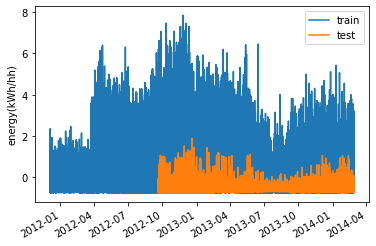

In [31]:
# split data, with the test in the future
n_split = -int(len(dfs_norm)*0.2)
df_train = dfs_norm[:n_split]
df_test = dfs_norm[n_split:]

# Show split
pd.concat(df_train)['energy(kWh/hh)'].plot(label='train')
pd.concat(df_test)['energy(kWh/hh)'].plot(label='test')
plt.ylabel('energy(kWh/hh)')
plt.legend()

### Dataset

In [32]:
# These are the columns that we wont know in the future
# We need to blank them out in x_future
columns_blank=['visibility',
       'windBearing', 'temperature', 'dewPoint', 'pressure',
       'apparentTemperature', 'windSpeed', 'humidity']

In [33]:
ds_train = Seq2SeqDataSets(df_train,
                          window_past=window_past,
                          window_future=window_future,
                          columns_blank=columns_blank)
ds_test = Seq2SeqDataSets(df_test,
                         window_past=window_past,
                         window_future=window_future,
                         columns_blank=columns_blank)
print(ds_train)
print(ds_test)

<Seq2SeqDataSets([<Seq2SeqDataSet(shape=(24170, 19), times=2012-10-12 11:30:00 to 2012-10-12 12:00:00 at 30T)>, <Seq2SeqDataSet(shape=(39247, 19), times=2011-12-03 09:00:00 to 2011-12-03 09:30:00 at 30T)>, <Seq2SeqDataSet(shape=(20082, 19), times=2012-03-22 15:30:00 to 2012-03-22 16:00:00 at 30T)>, <Seq2SeqDataSet(shape=(10875, 19), times=2012-05-08 10:30:00 to 2012-05-08 11:00:00 at 30T)>, <Seq2SeqDataSet(shape=(25368, 19), times=2012-09-17 12:30:00 to 2012-09-17 13:00:00 at 30T)>])>
<Seq2SeqDataSets([<Seq2SeqDataSet(shape=(25327, 19), times=2012-09-18 09:00:00 to 2012-09-18 09:30:00 at 30T)>])>


In [34]:
# we can treat it like an array
ds_train[0]
len(ds_train)
ds_train[-1]

[array([[-1.2801421 ,  0.4781144 , -1.2036566 , ...,  1.        ,
         -4.        ,  1.        ],
        [-1.2801421 ,  0.4781144 , -1.2036566 , ...,  1.        ,
         -3.9791667 ,  1.        ],
        [-1.2801421 ,  0.4781144 , -1.2036566 , ...,  1.        ,
         -3.9583333 ,  1.        ],
        ...,
        [-1.2801421 ,  0.819931  , -1.2036566 , ...,  1.        ,
         -0.0625    ,  1.        ],
        [-1.2801421 ,  0.93386984, -1.1411309 , ...,  1.        ,
         -0.04166667,  1.        ],
        [-1.2801421 ,  0.93386984, -1.1411309 , ...,  1.        ,
         -0.02083333,  1.        ]], dtype=float32),
 array([[-0.28339753],
        [-0.55615604],
        [-0.59887725],
        [-0.6366691 ],
        [-0.5808029 ],
        [-0.6563866 ],
        [-0.57423043],
        [-0.6629591 ],
        [-0.5775167 ],
        [-0.6465278 ],
        [-0.59723413],
        [-0.6268104 ],
        [-0.61859477],
        [-0.608736  ],
        [-0.6383122 ],
        [-0.5

,month,day,week,hour,minute,dayofweek,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,stdorToU,LCLid,Acorn_grouped,tsp_days,is_past
2014-02-23 17:00:00,-1.280142,0.819931,-1.203657,0.793780,-0.999965,1.501256,0.297982,0.108245,0.168823,-0.056013,-0.272611,0.320145,2.045089,-0.593609,-0.149527,0.0,0.0,1.0,-0.104167,1.0
2014-02-23 17:30:00,-1.280142,0.819931,-1.203657,0.793780,1.000035,1.501256,0.297982,0.108245,0.168823,-0.056013,-0.272611,0.320145,2.045089,-0.593609,-0.149527,0.0,0.0,1.0,-0.083333,1.0
2014-02-23 18:00:00,-1.280142,0.819931,-1.203657,0.938242,-0.999965,1.501256,0.297982,0.020721,0.098036,-0.096592,-0.240999,0.261351,1.902797,-0.522607,-0.149527,0.0,0.0,1.0,-0.062500,1.0
2014-02-23 18:30:00,-1.280142,0.819931,-1.203657,0.938242,1.000035,1.501256,0.297982,0.020721,0.098036,-0.096592,-0.240999,0.261351,1.902797,-0.522607,-0.149527,0.0,0.0,1.0,-0.041667,1.0
2014-02-23 19:00:00,-1.280142,0.819931,-1.203657,1.082703,-0.999965,1.501256,0.590561,-0.077744,0.059272,-0.092727,-0.216613,0.229155,1.201150,-0.451605,-0.149527,0.0,0.0,1.0,-0.020833,1.0


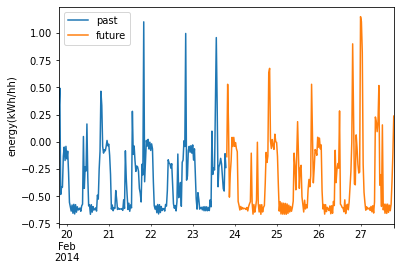

In [35]:
# We can get rows
x_past, y_past, x_future, y_future = ds_train.get_rows(10)

# Plot one instance, this is what the model sees
y_past['energy(kWh/hh)'].plot(label='past')
y_future['energy(kWh/hh)'].plot(ax=plt.gca(), label='future')
plt.legend()
plt.ylabel('energy(kWh/hh)')

# Notice we've added on two new columns tsp (time since present) and is_past
x_past.tail()

In [36]:
# Notice we've hidden some future columns to prevent cheating
x_future.tail()

,month,day,week,hour,minute,dayofweek,visibility,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,humidity,holiday,stdorToU,LCLid,Acorn_grouped,tsp_days,is_past
2014-02-27 17:00:00,-1.280142,1.275686,-1.141131,0.793780,-0.999965,0.001332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.149527,0.0,0.0,1.0,3.895833,0.0
2014-02-27 17:30:00,-1.280142,1.275686,-1.141131,0.793780,1.000035,0.001332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.149527,0.0,0.0,1.0,3.916667,0.0
2014-02-27 18:00:00,-1.280142,1.275686,-1.141131,0.938242,-0.999965,0.001332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.149527,0.0,0.0,1.0,3.937500,0.0
2014-02-27 18:30:00,-1.280142,1.275686,-1.141131,0.938242,1.000035,0.001332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.149527,0.0,0.0,1.0,3.958333,0.0
2014-02-27 19:00:00,-1.280142,1.275686,-1.141131,1.082703,-0.999965,0.001332,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.149527,0.0,0.0,1.0,3.979167,0.0


## Model

In [37]:

class Seq2SeqLSTMDecoder(nn.Module):
    def __init__(self, input_size, input_size_decoder, output_size, hidden_size=32, lstm_layers=2, lstm_dropout=0, _min_std = 0.05):
        super().__init__()
        self._min_std = _min_std

        self.encoder = nn.LSTM(
            input_size=input_size + output_size,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=lstm_layers,
            dropout=lstm_dropout,
        )
        self.decoder = nn.LSTM(
            input_size=input_size_decoder,
            hidden_size=hidden_size,
            batch_first=True,
            num_layers=lstm_layers,
            dropout=lstm_dropout,
        )
        self.mean = nn.Linear(hidden_size, output_size)
        self.std = nn.Linear(hidden_size, output_size)

    def forward(self, context_x, context_y, target_x, target_y=None):
        x = torch.cat([context_x, context_y], -1)
        _, (h_out, cell) = self.encoder(x)
        
        # output = [batch size, seq len, hid dim * n directions]
        outputs, (_, _) = self.decoder(target_x, (h_out, cell))
        
        # outputs: [B, T, num_direction * H]
        mean = self.mean(outputs)
        log_sigma = self.std(outputs)
        log_sigma = torch.clamp(log_sigma, np.log(self._min_std), -np.log(self._min_std))

        sigma = torch.exp(log_sigma)
        y_dist = torch.distributions.Normal(mean, sigma)
        return y_dist

## Lightning

In [38]:
import pytorch_lightning as pl

class PL_Seq2Seq(pl.LightningModule):
    def __init__(self, **hparams):
        super().__init__()
        self._model = Seq2SeqLSTMDecoder(**hparams)

    def forward(self, x_past, y_past, x_future, y_future=None):
        """Eval/Predict"""
        y_dist = self._model(x_past, y_past, x_future)
        return y_dist

    def training_step(self, batch, batch_idx):
        x_past, y_past, x_future, y_future = batch
        y_dist = self.forward(*batch)
        loss = -y_dist.log_prob(y_future).mean()
        self.log_dict({'loss/train':loss})
        return loss

    def validation_step(self, batch, batch_idx):
        x_past, y_past, x_future, y_future = batch
        y_dist = self.forward(*batch)
        loss = -y_dist.log_prob(y_future).mean()
        self.log_dict({'loss/val':loss})
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

In [39]:
from torch.utils.data import DataLoader, random_split
from pytorch_lightning.loggers import CSVLogger
from pl_bolts.callbacks import PrintTableMetricsCallback


In [40]:
input_size = x_past.shape[-1]
output_size = y_future.shape[-1]

model = PL_Seq2Seq(input_size=input_size,
                   input_size_decoder=input_size,
                   output_size=output_size,
                   hidden_size=32,
                   lstm_layers=2,
                   lstm_dropout=0.25).to(device)

logger = CSVLogger("logs", name="seq2seq")
trainer = pl.Trainer(gpus=1,
                     logger=logger)
dl_train = DataLoader(ds_train,
                      batch_size=batch_size,
                      shuffle=True,
                      num_workers=8)
dl_test = DataLoader(ds_test, batch_size=batch_size, num_workers=4)
trainer.fit(model, dl_train, dl_test)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name   | Type               | Params
----------------------------------------------
0 | _model | Seq2SeqLSTMDecoder | 30 K  


/home/wassname/anaconda/envs/seq2seq-time/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:45: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [41]:
df_hist = pd.read_csv(trainer.logger.experiment.metrics_file_path)
df_hist['epoch'] = df_hist['epoch'].ffill()
df_histe = df_hist.set_index('epoch').groupby('epoch').mean()
df_histe[['loss/train', 'loss/val']].plot()
df_histe

KeyError: "['loss/val'] not in index"

## Predict


In [43]:
ds_preds = predict(model.to(device), ds_test.datasets[0], batch_size, device=device, scaler=output_scaler)
ds_preds

<xarray.Dataset>
Dimensions:        (t_ahead: 192, t_behind: 192, t_source: 24943)
Coordinates:
  * t_source       (t_source) datetime64[ns] 2012-09-18T09:00:00 ... 2012-09-...
  * t_ahead        (t_ahead) timedelta64[ns] 00:00:00 ... 3 days 23:30:00
  * t_behind       (t_behind) timedelta64[ns] -4 days +00:00:00 ... -1 days +...
    t_target       (t_source, t_ahead) datetime64[ns] 2012-09-18T09:00:00 ......
    t_past         (t_source, t_behind) datetime64[ns] 2012-09-14T09:00:00 .....
    t_ahead_hours  (t_ahead) float64 0.0 0.0 1.0 1.0 2.0 ... 94.0 94.0 95.0 95.0
Data variables:
    y_past         (t_source, t_behind) float32 0.061000023 ... 0.12699997
    nll            (t_source, t_ahead) float32 0.44390392 ... 0.79414505
    y_pred         (t_source, t_ahead) float32 0.33915406 ... 0.37555674
    y_pred_std     (t_source, t_ahead) float64 0.3371 0.332 ... 0.3789 0.379
    y_true         (t_source, t_ahead) float32 0.17700002 ... 0.05900002

In [44]:
# TODO Metrics... smape etc

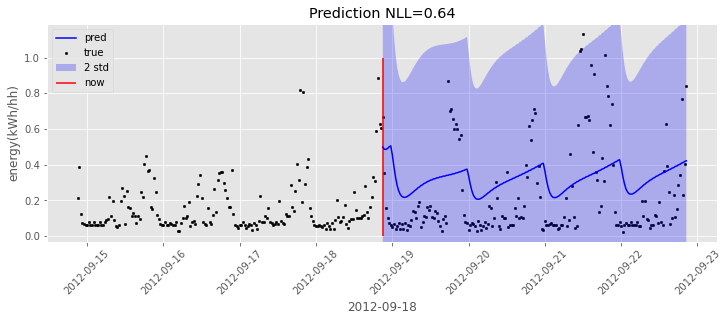

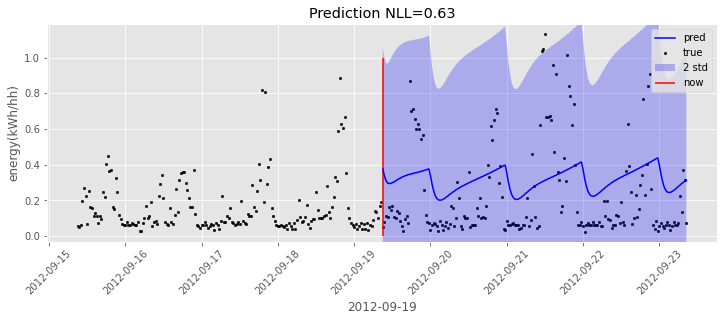

In [52]:
def plot_prediction(ds_preds, i):
    """Plot a prediction into the future, at a single point in time."""
    d = ds_preds.isel(t_source=i)

    # Get arrays
    xf = d.t_target
    yp = d.y_pred
    s = d.y_pred_std
    yt = d.y_true
    now = d.t_source.squeeze()
    
    
    plt.figure(figsize=(12, 4))
    
    plt.scatter(xf, yt, label='true', c='k', s=6)
    ylim = plt.ylim()

    # plot prediction
    plt.fill_between(xf, yp-2*s, yp+2*s, alpha=0.25,
            facecolor="b",
            interpolate=True,
            label="2 std",)
    plt.plot(xf, yp, label='pred', c='b')

    # plot true
    plt.scatter(
        d.t_past,
        d.y_past,
        c='k',
        s=6
    )
    
    # plot a red line for now
    plt.vlines(x=now, ymin=0, ymax=1, label='now', color='r')
    plt.ylim(*ylim)

    now=pd.Timestamp(now.values)
    plt.title(f'Prediction NLL={d.nll.mean().item():2.2g}')
    plt.xlabel(f'{now.date()}')
    plt.ylabel('energy(kWh/hh)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()
    
# plot_prediction(ds_preds, 0) 
# plot_prediction(ds_preds, 12) # 6 hours later
plot_prediction(ds_preds, 24) # 12 hours later
plot_prediction(ds_preds, 48) # 12 hours later

## Error vs time ahead

Text(0.5, 1.0, 'NLL vs time (no. samples=24943)')

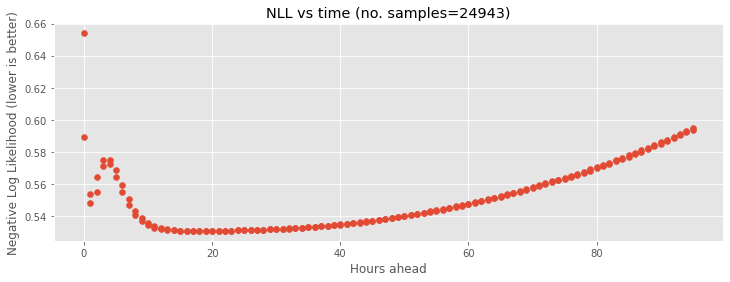

In [53]:
ds_preds.mean('t_source').plot.scatter('t_ahead_hours', 'nll') # Mean over all predictions

# Tidy the graph
n = len(ds_preds.t_source)
plt.ylabel('Negative Log Likelihood (lower is better)')
plt.xlabel('Hours ahead')
plt.title(f'NLL vs time (no. samples={n})')

1

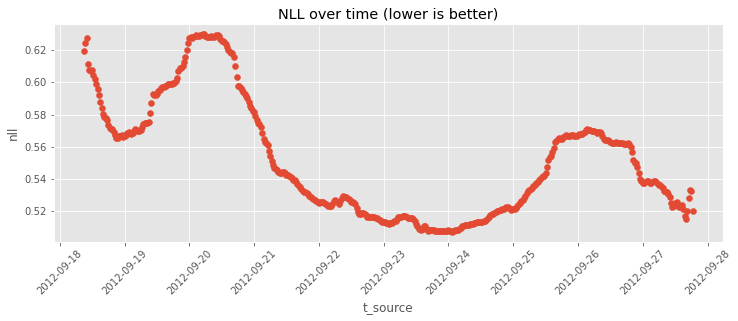

In [54]:
# Make a plot of the NLL over time. Does this solution get worse with time?
d = ds_preds.mean('t_ahead').groupby('t_source').mean().plot.scatter('t_source', 'nll')
plt.xticks(rotation=45)
plt.title('NLL over time (lower is better)')
1

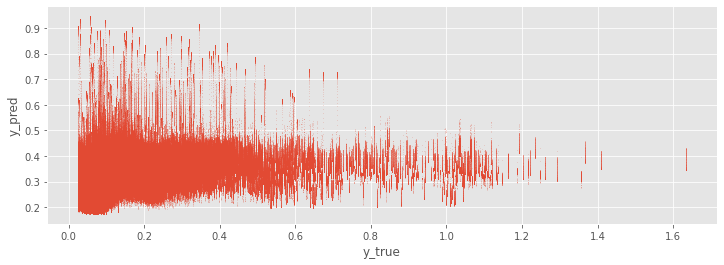

In [55]:
# A scatter plot is easy with xarray
ds_preds.plot.scatter('y_true', 'y_pred', s=.01)